# Week 4 Notebook

## Track 2 TODO 1:  Retrieve predicted segmentation mask and estimated joints from pretrained network
 
For the first part of our animation pipeline, we will use the pretrained objection detection model and segmentation method from author's implementation to obtain a segmentation mask for our own drawing. Your first task is:
1. Go to the Github repository https://github.com/facebookresearch/AnimatedDrawings/tree/main, follow the instructions in "animating-your-own-drawing" https://github.com/facebookresearch/AnimatedDrawings/tree/main#animating-your-own-drawing) to obtain a segmentation mask "mask.png", a texture map "texture.png", and locations of detected joint skeleton in "char_cfg.yaml" using the example drawing "garlic.png"
2. Write code to load the segmentation mask and the original image, compose and visualize a masked image using Matplotlib
3. Load detected joint locations, use Matplotlib to visualize the locations and labels of the joints. Visualize the tree hierarchy of the skeleton using lines (See desired output in session slide)
4. Make your own drawing, and repeat step 1-3 

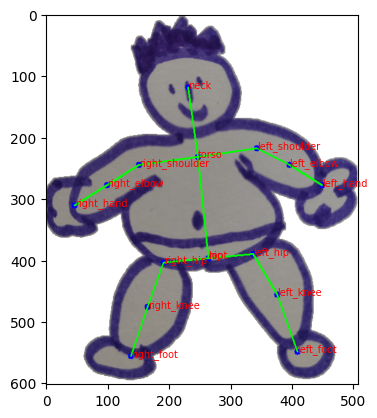

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('char1/mask.png')
background = np.bitwise_not(img)
ori_img = cv2.imread('char1/texture.png')
img = np.bitwise_and(img, ori_img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.add(img, background)
plt.imshow(img)

import yaml
with open('char1/char_cfg.yaml') as f:
    data = yaml.load(f, Loader=yaml.FullLoader)

for joint in data['skeleton']:
    cv2.circle(img, tuple(joint['loc']), 5, (0, 0, 255), -1)
    plt.text(joint['loc'][0],joint['loc'][1],joint['name'],color='red',fontsize=7)
plt.imshow(img)

for node in data['skeleton']:
    if node['parent'] is not None:
        for name in data['skeleton']:
            if name['name'] == node['parent']:
                cv2.line(img, tuple(node['loc']), tuple(name['loc']), (0, 255, 0), 2)
plt.imshow(img)

## Track 2 TODO 2:  2D Mesh Generation using delaunay triangulation
For the second part of our animation pipeline, we need to generate a 2D mesh from our masked image that we can use for rigging during the animation phase. Your task is
1. Generate random points using Poisson Disk Sampling (https://medium.com/@hemalatha.psna/implementation-of-poisson-disc-sampling-in-javascript-17665e406ce1) as points in our mesh
2. Use Delaunay triangulation to generate a 2D triangle mesh from sampled points
3. Visualize the generated 2D mesh using Matplotlib


Poisson Disk Sampling... Total number of points: 165618


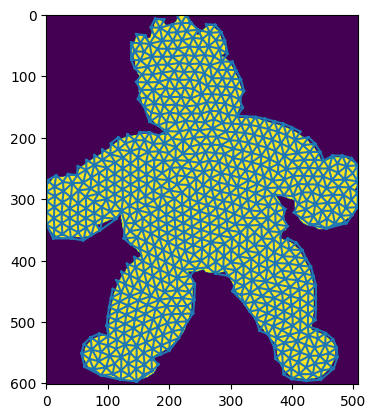

In [107]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import numpy as np 
import matplotlib.tri as tri
random.seed(1)
img = cv2.imread('char1/mask.png', cv2.IMREAD_GRAYSCALE)
_, img = cv2.threshold(img, 127, 1, cv2.THRESH_BINARY)
kernel = np.ones((5, 5), np.uint8) 
img_dilation = cv2.dilate(img, kernel, iterations=2)
x, y = np.where(img_dilation == 1)
points = list(np.stack((x, y), axis=-1))
background = np.bitwise_not(img)

def count_distance(p0,p1):
    return np.linalg.norm(p0-p1)

def poissonDiskSampling(points,r):
    i = 0
    while i < len(points):
        j = i+1
        while j<len(points):
            if count_distance(points[i],points[j]) <= r:
                points.pop(j)
                j -= 1
            j += 1
        i += 1
    return points
print("Poisson Disk Sampling... Total number of points:", len(points))
points = poissonDiskSampling(points,15)

def generate_triangles(points):
    x = np.array([point[1] for point in points])
    y = np.array([point[0] for point in points])
    Triangle = tri.Triangulation(x,y)
    xmean = x[Triangle.triangles].mean(axis = 1)
    ymean = y[Triangle.triangles].mean(axis = 1)

    i = 0
    while i < len(Triangle.triangles):
        if background[int(ymean[i]),int(xmean[i])] == 255:
            Triangle.triangles = np.delete(Triangle.triangles,i,axis = 0)
            ymean = np.delete(ymean,i)
            xmean = np.delete(xmean,i)
            i -= 1
            continue
        i += 1

    return Triangle

Triangle = generate_triangles(points)

plt.imshow(img)
plt.triplot(Triangle)
plt.show()

# Week 5 Notebook

## Track 2 TODO 1: Render your generated 2D mesh with texture
We are now ready to render our 2D mesh with a rendering engine (PyVista) using the generated 2D mesh. To do so,
1. Output your generated 2D mesh into an obj format (https://en.wikipedia.org/wiki/Wavefront_.obj_file). Since our mesh is 2D, you can set the coordinate for z-axis to be 0. Make sure to include the computed texture coordinate for each triangle vertex, where the texture is the original drawing image. You can compute the texture coordinate for each vertex with pixel location $(p_x, p_y)$ using $ (p_x/width, p_y/height) $
2. Load your obj file using the trimesh library's mesh = trimesh.load(file_path) function. You can then initialize a plotter object in PyVista using plotter = pyvista.Plotter(...). Load your drawing as a texture file, then use plotter.add_mesh(mesh, texture=...) (https://docs.pyvista.org/version/stable/api/plotting/_autosummary/pyvista.Plotter.add_mesh.html) to create a textured mesh.
3. Visualize the textured mesh by calling plotter.show()

/Users/jiangfulin/miniconda3/envs/animated_drawings/lib/python3.12/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


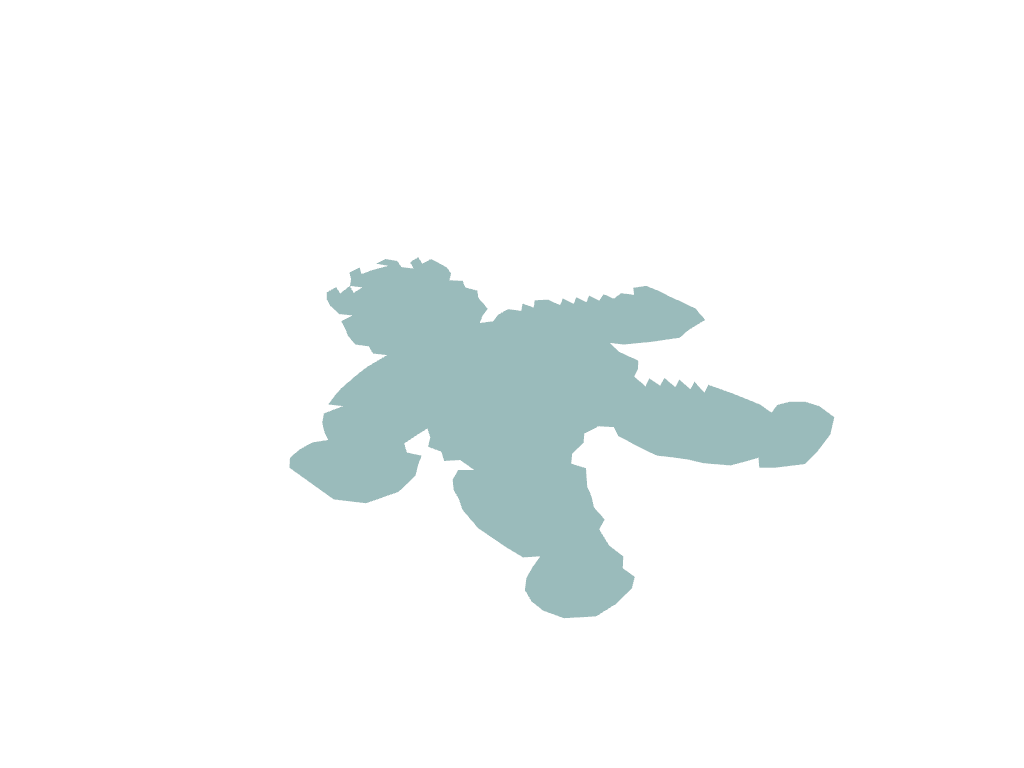

In [108]:
import pyvista as pv
import trimesh
from PIL import Image
# output triangle as obj file
img = cv2.imread('char1/mask.png')
height, width = img.shape[:2]
# with open('char1/char1.obj','w') as f:
#     for tria in Triangle.triangles:
#         f.write(f"f ({x[tria][0]/width},{y[tria][0]/height}) ({x[tria][1]/width},{y[tria][1]/height}) ({x[tria][2]/width},{y[tria][2]/height})\n")

def visualize_mesh(Triangle):
    with open('char1/char1.obj','w') as f:
        for i in range(len(Triangle.x)):
            f.write(f"v {Triangle.x[i]} {Triangle.y[i]} {0}\n")
        for i in range(len(Triangle.triangles)):
            f.write(f"f {Triangle.triangles[i][0]+1}//{i+1} {Triangle.triangles[i][1]+1}//{i+1} {Triangle.triangles[i][2]+1}//{i+1}\n")

    mesh = trimesh.load('char1/char1.obj')
    # texture_im = Image.open('char1/texture.png')
    # texture = trimesh.visual.TextureVisuals(image=texture_im)
    plotter = pv.Plotter()
    plotter.add_mesh(mesh)
    plotter.show()

visualize_mesh(Triangle=Triangle)

## Track 2 TODO 2: Use As-Rigid-As-Possible to deform your mesh.
Our animation pipeline will use the As-Rigid-As-Possible algorithm to animate our textured 2D mesh. You can reference Animated Drawing for an example implementation of the ARAP algorithm (https://github.com/facebookresearch/AnimatedDrawings/blob/main/animated_drawings/model/arap.py). 
1. Add ARAP to your pipeline, which allows you to supply as inputs the vertices to deform (vertices on your 2D textured mesh), handle locations (the detected joints for the drawing), target handle locations (target location for the joints) and output the positions for the deformed mesh.
2. Modify the character joint location you loaded to create a new target pose, then use ARAP to compute the deformed mesh.
3. Visualize the deformed mesh using the visualization pipeline you created in TODO 1

In [109]:
joints = []
for joint in data['skeleton']:
    joints.append(joint['loc'][::-1])
np.array(joints)

array([[397, 264],
       [397, 264],
       [232, 247],
       [119, 231],
       [245, 151],
       [278,  99],
       [311,  46],
       [218, 343],
       [245, 396],
       [278, 449],
       [404, 191],
       [476, 165],
       [556, 138],
       [390, 337],
       [456, 376],
       [549, 409]])

/Users/jiangfulin/miniconda3/envs/animated_drawings/lib/python3.12/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


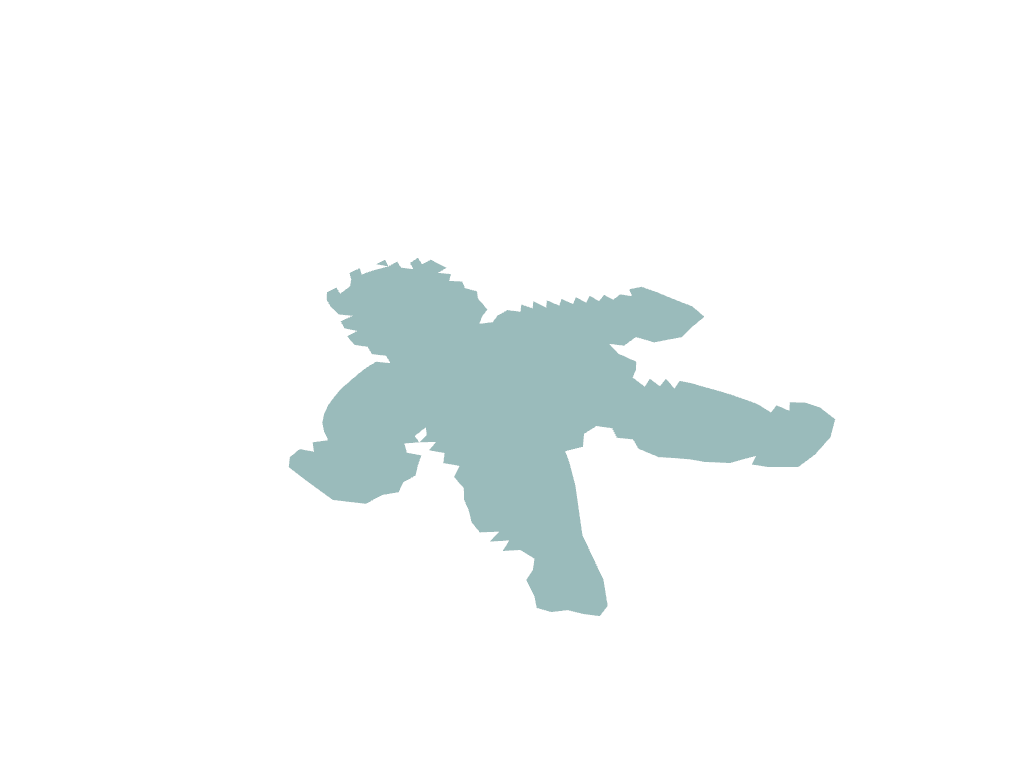

In [110]:
from arap import ARAP, plot_mesh
deformed_mesh = ARAP(np.array(joints), Triangle.triangles, np.array(points))
new_joints = joints.copy()
new_joints[13] = [390, 357]
new_joints[14] = [456, 406]
new_joints[15] = [549, 439]
new_points = deformed_mesh.solve(np.array(new_joints))
new_triangles = generate_triangles(new_points)
visualize_mesh(new_triangles)